In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from transformers import AutoModelForSequenceClassification

# 載入已經訓練好的模型
model_1 = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP電商專案/final/MacBERT_results/').to(device)
model_2 = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP電商專案/final/BERT_results/').to(device)


models = [model_1, model_2]

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/NLP電商專案/資料爬蟲/final227.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/NLP電商專案/資料爬蟲/final227.csv'

In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback


label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])

# 先把 20% 的數據作為測試集
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['Comment'].tolist(),
    df['Rating'].tolist(),
    test_size=0.2,  # 20% 測試集
    random_state=42,
    stratify=df['Rating'].tolist()  # 確保測試集和訓練集的比例相同
)

# 再從剩下的 80% 裡取 20% 當驗證集（相當於原始數據的 16%）
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,  # 20% of 80% = 16%
    random_state=42,
    stratify=train_val_labels  # 確保驗證集和訓練集的比例相同
)

tokenizer = AutoTokenizer.from_pretrained('hfl/chinese-macbert-base')
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Convert train and validation data to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': val_texts, 'label': val_labels}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_texts, 'label': test_labels}))

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch (input_ids, attention_mask, and label)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/21120 [00:00<?, ? examples/s]

Map:   0%|          | 0/5280 [00:00<?, ? examples/s]

Map:   0%|          | 0/6600 [00:00<?, ? examples/s]

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def average_ensemble(models, dataloader, device):
    all_probs = []

    for model in models:
        model.eval()
        model.to(device)
        probs = []

        with torch.no_grad():
            for batch in dataloader:
                inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
                outputs = model(**inputs)
                softmax_probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()  # 取得 softmax 機率
                probs.append(softmax_probs)

        all_probs.append(np.concatenate(probs, axis=0))  # 存每個模型的機率

    avg_probs = np.mean(all_probs, axis=0)  # 計算機率的平均值
    final_preds = np.argmax(avg_probs, axis=1)  # 取得機率最高的類別
    return final_preds

# 創建測試 DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 進行 Averaging Ensemble 預測
final_predictions = average_ensemble(models, test_dataloader, device)


Averaging Ensemble Accuracy: 0.9126


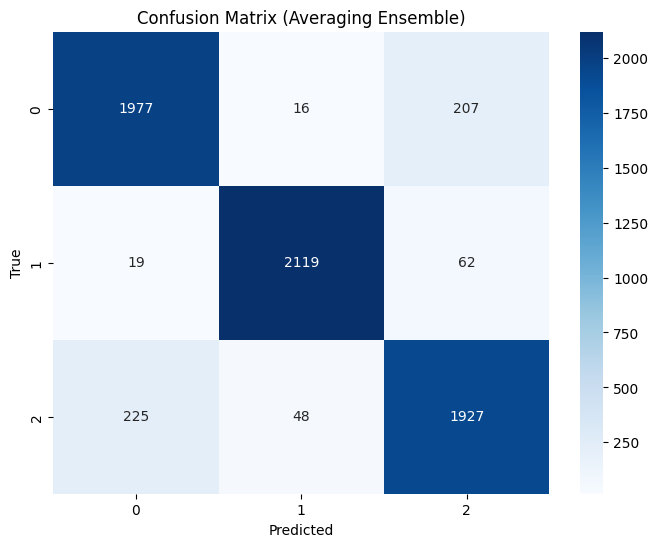

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 計算準確率
accuracy = accuracy_score(test_labels, final_predictions)
print(f"Averaging Ensemble Accuracy: {accuracy:.4f}")

# 混淆矩陣
cm = confusion_matrix(test_labels, final_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Averaging Ensemble)')
plt.show()


In [ ]:
from transformers import AutoModelForSequenceClassification

# 載入已經訓練好的模型
model_1 = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP電商專案/final/NEW_BERT_result/').to(device)
model_2 = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP電商專案/final/NEW_MacBERT_result/').to(device)


models = [model_1, model_2]

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/NLP電商專案/資料爬蟲/final227.csv')

In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback


label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])

# 先把 20% 的數據作為測試集
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['Comment'].tolist(),
    df['Rating'].tolist(),
    test_size=0.2,  # 20% 測試集
    random_state=42,
    stratify=df['Rating'].tolist()  # 確保測試集和訓練集的比例相同
)

# 再從剩下的 80% 裡取 20% 當驗證集（相當於原始數據的 16%）
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,  # 20% of 80% = 16%
    random_state=42,
    stratify=train_val_labels  # 確保驗證集和訓練集的比例相同
)

tokenizer = AutoTokenizer.from_pretrained('hfl/chinese-macbert-base')
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Convert train and validation data to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': val_texts, 'label': val_labels}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_texts, 'label': test_labels}))

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch (input_ids, attention_mask, and label)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/21120 [00:00<?, ? examples/s]

Map:   0%|          | 0/5280 [00:00<?, ? examples/s]

Map:   0%|          | 0/6600 [00:00<?, ? examples/s]

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def average_ensemble(models, dataloader, device):
    all_probs = []

    for model in models:
        model.eval()
        model.to(device)
        probs = []

        with torch.no_grad():
            for batch in dataloader:
                inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
                outputs = model(**inputs)
                softmax_probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()  # 取得 softmax 機率
                probs.append(softmax_probs)

        all_probs.append(np.concatenate(probs, axis=0))  # 存每個模型的機率

    avg_probs = np.mean(all_probs, axis=0)  # 計算機率的平均值
    final_preds = np.argmax(avg_probs, axis=1)  # 取得機率最高的類別
    return final_preds

# 創建測試 DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 進行 Averaging Ensemble 預測
final_predictions = average_ensemble(models, test_dataloader, device)


Averaging Ensemble Accuracy: 0.9153
Averaging Ensemble F1 Score: 0.9152


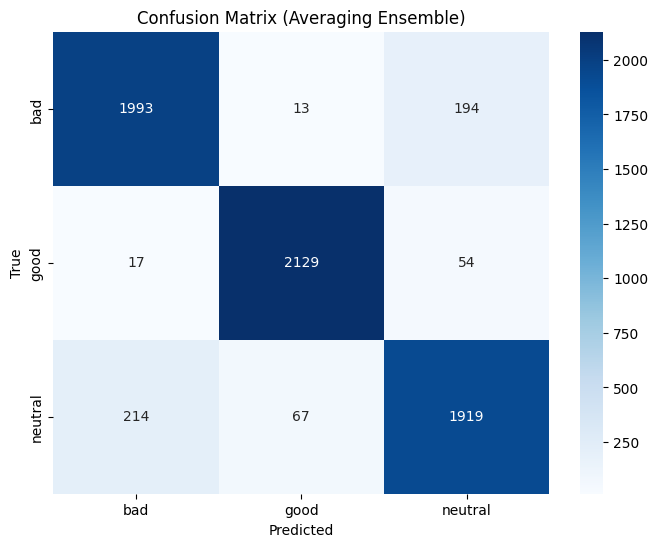

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 計算準確率
accuracy = accuracy_score(test_labels, final_predictions)
print(f"Averaging Ensemble Accuracy: {accuracy:.4f}")

# 計算 F1 分數（這裡是針對每個類別的 F1 分數計算平均值）
f1 = f1_score(test_labels, final_predictions, average='weighted')  # 你可以選擇 'micro', 'macro', 或 'weighted' 等選項
print(f"Averaging Ensemble F1 Score: {f1:.4f}")

# 混淆矩陣
cm = confusion_matrix(test_labels, final_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Averaging Ensemble)')
plt.show()
